In [1]:
#read dfs# import packages
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
quan_train_x=pd.read_csv("../input/garanti-mustafa/quan_train_x.csv")
quan_train_y=pd.read_csv("../input/garanti-mustafa/quan_train_y.csv")
quan_test=pd.read_csv("../input/garanti-mustafa/quan_test.csv")

label_enc_train_x=pd.read_csv("../input/garanti-mustafa/label_enc_train_x.csv")
label_enc_train_y=pd.read_csv("../input/garanti-mustafa/label_enc_train_y.csv")
label_enc_test=pd.read_csv("../input/garanti-mustafa/label_enc_test.csv")

onehot_train_x=pd.read_csv("../input/garanti-mustafa/onehot_train_x.csv")
onehot_train_y=pd.read_csv("../input/garanti-mustafa/onehot_train_y.csv")
onehot_test=pd.read_csv("../input/garanti-mustafa/onehot_test.csv")

onehot_df=pd.read_csv("../input/garanti-mustafa/onehot_df.csv")
quantile_df=pd.read_csv("../input/garanti-mustafa/quantile_df.csv")

In [3]:
xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=100).get_params()

NameError: name 'xgb' is not defined

In [4]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import ShuffleSplit

def xgboostcv(max_depth,
              learning_rate,
              n_estimators,
              gamma,
              min_child_weight,
              max_delta_step,
              max_leaves,
              subsample,
              reg_alpha,
              reg_lambda,
              colsample_bytree,
              verbosity=0,
              nthread=-1,
              random_state=0,
              tree_method="gpu_hist"):
    
    model=xgb.XGBRegressor(max_depth=int(round(max_depth)),
                           learning_rate=learning_rate,
                           n_estimators=int(round(n_estimators)),
                           verbosity=verbosity,
                           nthread=nthread,
                           gamma=gamma,
                           min_child_weight=min_child_weight,
                           max_delta_step=int(round(max_delta_step)),
                           max_leaves=int(round(max_leaves)),
                           subsample=subsample,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           colsample_bytree=colsample_bytree,
                           tree_method=tree_method,
                           random_state=random_state)
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    result = cross_val_score(model,onehot_train_x,onehot_train_y,scoring="neg_root_mean_squared_error",cv=cv).mean()
    return result


# Load data set and target values
xgboostBO = BayesianOptimization(f = xgboostcv,
                                 pbounds = {'max_depth': (4, 10),
                                          'learning_rate': (0.01, 0.3),
                                          'n_estimators': (50, 1000),
                                          'gamma': (1., 0.01),
                                          'min_child_weight': (1, 50),
                                          'max_delta_step': (0,10),
                                          "max_leaves": (10,90),
                                          'subsample': (0.4, 1),
                                          'reg_alpha': (0.001, 1.),
                                          'reg_lambda': (0.001, 1.),
                                          'colsample_bytree' :(0.4, 0.1)
                                          },
                                random_state=1)
# probe default params
xgboostBO.probe({'max_depth': 6,
              'learning_rate': 0.3,
              'n_estimators': 100,
              'gamma': 0,
              'min_child_weight': 1,
              'max_delta_step': 0,
              "max_leaves": 0,
              'subsample': 1,
              'reg_alpha': 0,
              'reg_lambda': 1,
              'colsample_bytree' :1})

xgboostBO.maximize(init_points=1, n_iter=500)
print('-'*53)

print('Final Results')
for res in xgboostBO.res:
    print('XGBOOST: %f' % res['target'])

print('*'*53)
print('best params ==>', xgboostBO.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | max_le... | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.342e+0 |  1.0      |  0.0      |  0.3      |  0.0      |  6.0      |  0.0      |  1.0      |  100.0    |  0.0      |  1.0      |  1.0      |
|  2        | -6.339e+0 |  0.2749   |  0.2869   |  0.01003  |  3.023    |  4.881    |  17.39    |  10.13    |  378.3    |  0.3974   |  0.5393   |  0.6515   |
|  3        | -6.328e+0 |  0.1      |  0.01     |  0.2852   |  0.8464   |  8.087    |  14.28    |  11.24    |  377.9    |  0.532    |  0.1359   |  0.5482   |
|  4        | -6.32e+03 |  0.1      |  0.01     |  0.1499   |  1.881    |  9.562    |  12.37    |  35.3     |  591.3    |  0.8281   |  0.5175   |  0.757    |
|  5        | -6.281e+0 |  0.1      |  0.01     |  0

In [5]:
param_dict = xgboostBO.max['params'] 
param_dict['tree_method']='gpu_hist'

# we need to round some float values to integer since these parameters works only in integer
param_dict['max_depth']=int(round(param_dict['max_depth']))
#param_dict['n_estimators']=10000
param_dict['n_estimators']=int(round(param_dict['n_estimators']))
param_dict['max_delta_step']=int(round(param_dict['max_delta_step']))
param_dict['max_leaves']=int(round(param_dict['max_leaves']))
param_dict['random_state']=0

# STRAIGHT PREDICTION

In [6]:
best_xgb_model = xgb.XGBRegressor()
best_xgb_model.set_params(**param_dict)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.1, gamma=0.01,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.29550851736280753, max_delta_step=10, max_depth=5,
             max_leaves=46, min_child_weight=15.833491409150358, missing=nan,
             monotone_constraints=None, n_estimators=964, n_jobs=None,
             num_parallel_tree=None, random_state=0,
             reg_alpha=0.10691963794169322, reg_lambda=0.9896469251720789,
             scale_pos_weight=None, subsample=0.4908066764651642,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)

In [7]:
best_xgb_model.fit(onehot_train_x,onehot_train_y)
#best_xgb_model.fit(
#    onehot_train_x,
#    onehot_train_y,
#    eval_set=[(onehot_train_x, onehot_train_y)],
#    eval_metric='rmse',
#    early_stopping_rounds=100  #30
#)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0.01, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.29550851736280753, max_delta_step=10, max_depth=5,
             max_leaves=46, min_child_weight=15.833491409150358, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=964, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.10691963794169322, reg_lambda=0.9896469251720789,
             scale_pos_weight=1, subsample=0.4908066764651642,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [8]:
best_xgb_model.get_booster().best_iteration

963

In [9]:
y_pred = best_xgb_model.predict(onehot_test)


In [10]:
len(np.unique(y_pred))

15496

(array([1.000e+00, 2.000e+00, 3.000e+00, 1.200e+01, 2.100e+01, 3.700e+01,
        8.300e+01, 1.650e+02, 2.810e+02, 3.940e+02, 6.080e+02, 8.030e+02,
        1.016e+03, 1.094e+03, 1.081e+03, 9.360e+02, 7.660e+02, 5.620e+02,
        4.990e+02, 4.120e+02, 3.370e+02, 3.260e+02, 3.020e+02, 2.900e+02,
        2.150e+02, 2.140e+02, 2.340e+02, 1.860e+02, 1.640e+02, 1.510e+02,
        1.550e+02, 1.330e+02, 1.470e+02, 1.340e+02, 1.210e+02, 1.150e+02,
        1.210e+02, 9.000e+01, 8.700e+01, 1.060e+02, 9.000e+01, 1.080e+02,
        8.000e+01, 8.600e+01, 8.900e+01, 7.500e+01, 9.400e+01, 8.500e+01,
        8.300e+01, 7.500e+01, 8.100e+01, 8.200e+01, 8.400e+01, 7.300e+01,
        7.200e+01, 6.600e+01, 7.700e+01, 5.300e+01, 9.300e+01, 5.800e+01,
        5.600e+01, 7.300e+01, 4.900e+01, 6.200e+01, 5.200e+01, 5.300e+01,
        5.900e+01, 6.300e+01, 6.200e+01, 5.600e+01, 7.100e+01, 6.100e+01,
        4.500e+01, 5.900e+01, 5.100e+01, 4.700e+01, 4.600e+01, 4.200e+01,
        5.500e+01, 6.000e+01, 5.200e+0

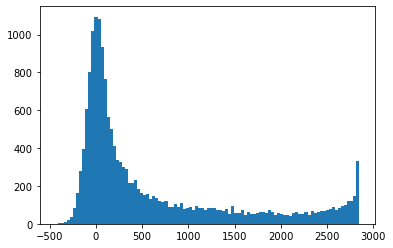

In [11]:
plt.hist(y_pred, bins=100)

In [12]:
np.sum(y_pred<0)

3961

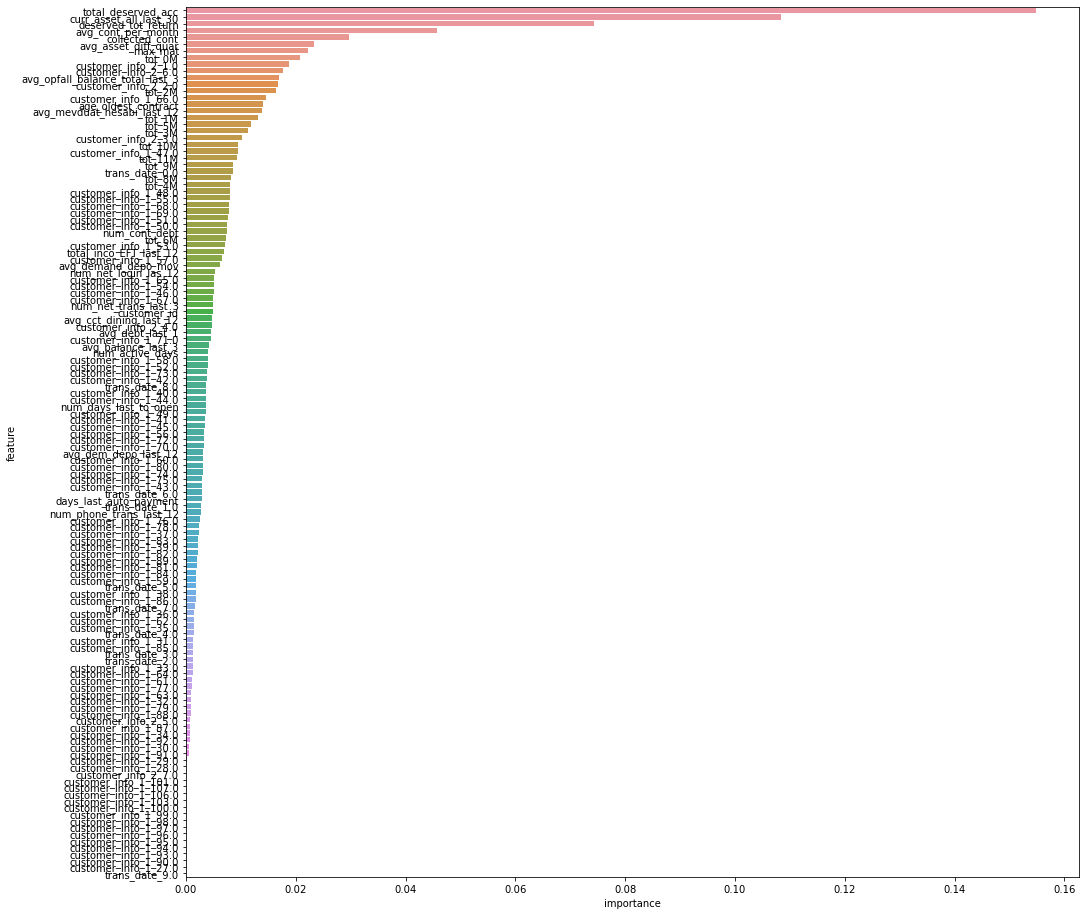

In [13]:
importance_df=pd.DataFrame(zip(onehot_test.columns.tolist(),best_xgb_model.feature_importances_),columns=["feature","importance"])

import seaborn as sns
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False), x='importance', y='feature')

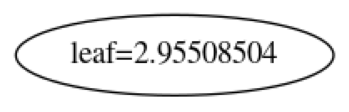

In [14]:
from xgboost import plot_tree
plot_tree(best_xgb_model, num_trees=0)

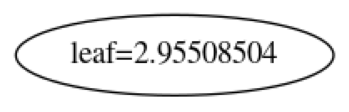

In [15]:
plot_tree(best_xgb_model, num_trees=1)

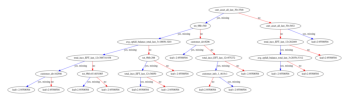

In [16]:
plot_tree(best_xgb_model, num_trees=50)

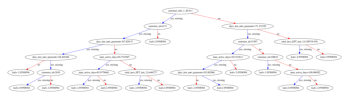

In [17]:
plot_tree(best_xgb_model, num_trees=100)

# PREDICTION w CV

In [18]:
from sklearn.metrics import mean_squared_error
import gc
import math

# https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def train_model(data_, test_, y_, folds_, best_params_dict):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])

    feature_importance_df = pd.DataFrame()

    feats = test_.columns.tolist()

    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_, y_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]

        # parameters found by Bayesian optimization
        clf = xgb.XGBRegressor()
        clf.set_params(**best_params_dict)

        clf.fit(
            trn_x,
            trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='rmse',
            early_stopping_rounds=100  #30
        )

        oof_preds[val_idx] = clf.predict(val_x)
        sub_preds += clf.predict(test_[feats]) / folds_.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Fold %2d RMSE : %.6f' %
              (n_fold + 1, math.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()

    print('Full RMSE score %.6f' % math.sqrt(mean_squared_error(y_, oof_preds)))

    df_sub_preds = pd.DataFrame({'customer_id':test_["customer_id"], 'PREDICTION':sub_preds})
    df_sub_preds = df_sub_preds[['customer_id', 'PREDICTION']]
    
    df_oof_preds = pd.DataFrame({'customer_id':data_["customer_id"].values, 'TARGET':y_.iloc[:,0], 'PREDICTION':oof_preds})
    df_oof_preds = df_oof_preds[['customer_id', 'TARGET', 'PREDICTION']]

    return oof_preds, df_oof_preds, df_sub_preds, \
            feature_importance_df, math.sqrt(mean_squared_error(y_, oof_preds))

In [19]:
folds = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

oof_preds, df_oof_preds, test_preds, importances, score = \
    train_model(onehot_train_x, onehot_test, onehot_train_y, folds, param_dict)

[0]	validation_0-rmse:8141.22852	validation_1-rmse:7123.08545
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:8140.94727	validation_1-rmse:7122.75732
[2]	validation_0-rmse:8140.66748	validation_1-rmse:7122.43066
[3]	validation_0-rmse:8140.38818	validation_1-rmse:7122.10498
[4]	validation_0-rmse:8140.10986	validation_1-rmse:7121.78076
[5]	validation_0-rmse:8139.83301	validation_1-rmse:7121.45703
[6]	validation_0-rmse:8139.55664	validation_1-rmse:7121.13574
[7]	validation_0-rmse:8139.28223	validation_1-rmse:7120.81494
[8]	validation_0-rmse:8139.00781	validation_1-rmse:7120.49463
[9]	validation_0-rmse:8138.73584	validation_1-rmse:7120.17676
[10]	validation_0-rmse:8138.46240	validation_1-rmse:7119.85791
[11]	validation_0-rmse:8138.19092	validation_1-rmse:7119.54199
[12]	validation_0-rmse:8137.92139	validation_1-rmse:7119.22705
[13]	validation_0-rmse:8137.652

In [20]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = importances[["feature", "importance"]].groupby(
        "feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index()

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=cols)
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgboost_importances-01.png')

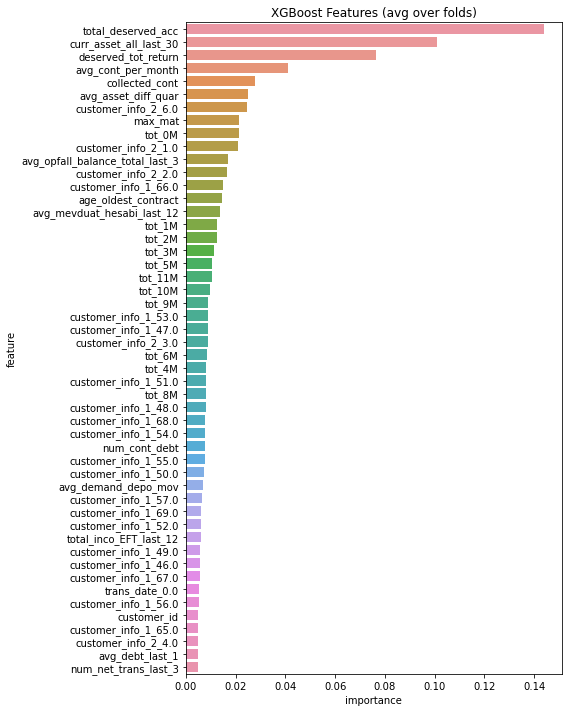

In [21]:
display_importances(feature_importance_df_=importances)

# SUBMISSIONS

In [22]:
# straight prediction results
submission_df=pd.DataFrame(zip(onehot_test["customer_id"],y_pred), columns=["Id", "Predicted"])
submission_df.to_csv('onehot_straight.csv', index=False)

In [23]:
# cv prediction results
submission_df2=pd.DataFrame(zip(test_preds["customer_id"],test_preds["PREDICTION"]), columns=["Id", "Predicted"])
submission_df2.to_csv('onehot_CV.csv', index=False)